# Analyse Tree Data

In [11]:
import json
import os
import copy

from torch import nn
import torch
import numpy as np
import pandas as pd
import h5py
import tqdm
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import concurrent.futures
from tqdm import tqdm
from collections import Counter
import decord
import cv2

from mllm.tools.extract_verb_sentence import VocabularyFilter
from mllm.dataset.utils import save_to_json, save_to_jsonl, read_json_file, read_jsonl_file, read_txt_file

def get_video_duration(video_path, loader_type = 'decord'):
    if loader_type == 'decord':
        vr = decord.VideoReader(video_path)
        vlen = len(vr)
        fps = vr.get_avg_fps()
        duration = float(vlen / fps)
        vr = None  # 这会导致VideoReader对象被垃圾回收，释放资源
        return duration
    elif loader_type == 'opencv':
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError("Could not open the video: ", video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = float(total_frames) / fps
        cap.release()

        return duration
    
def match_file_with_basename(directory, basename):
    for filename in os.listdir(directory):
        if filename.startswith(basename) and os.path.isfile(os.path.join(directory, filename)):
            return filename
    
def reoganize_std_jsonl(std_data: list)->list:
    videos = []
    tree_std_data_list = []
    
    for i in tqdm(std_data): # i为原始数据
        if i['video'] not in videos: # 当前没有视频，初始化
            tree_std_data = {}
            tree_std_data['captions'] = []
            tree_std_data['timestamps'] = []
            videos.append(i['video'])
            tree_std_data['video'] = i['video']
            tree_std_data['duration'] = i['duration']
            tree_std_data['source'] = i['source']
            tree_std_data['clip'] = i['clip']
            tree_std_data['captions'].append(i['captions'])
            tree_std_data['timestamps'].append([i['timestamps']])
            tree_std_data_list.append(tree_std_data)
        else: # 有视频
            tree_std_data = tree_std_data_list[videos.index(i['video'])]
            if i['captions'] not in tree_std_data['captions']: # 没有相同caption
                tree_std_data['captions'].append(i['captions'])
                tree_std_data['timestamps'].append([i['timestamps']]) # 这有问题，captions没进来
            else: # 有相同caption
                timestamps_idx = tree_std_data['captions'].index(i['captions'])
                tree_std_data['timestamps'][timestamps_idx].append(i['timestamps'])
            
                        
    return tree_std_data_list

vocabfilter = VocabularyFilter()

In [12]:
dataset_name_list = ['didemo', 'activitycaption', 'charadessta', 'qvhighlights']

dd_train_tree = read_jsonl_file('data/didemo_train_tree.jsonl')
ac_train_tree = read_jsonl_file('data/activitycaption_train_tree.jsonl')
ch_train_tree = read_jsonl_file('data/charadessta_train_tree.jsonl')
qv_train_tree = read_jsonl_file('data/qvhighlights_train_tree.jsonl')
train_tree_list = [dd_train_tree, ac_train_tree, ch_train_tree, qv_train_tree]

dd_train = read_jsonl_file('data/didemo_train.jsonl')
ac_train = read_jsonl_file('data/activitycaption_train.jsonl')
ch_train = read_jsonl_file('data/charadessta_train.jsonl')
qv_train = read_jsonl_file('data/qvhighlights_train.jsonl')
train_list = [dd_train, ac_train, ch_train, qv_train]

max_len:  9


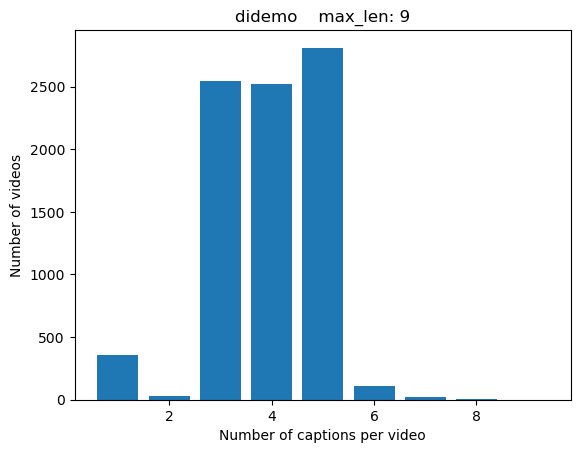

max_len:  27


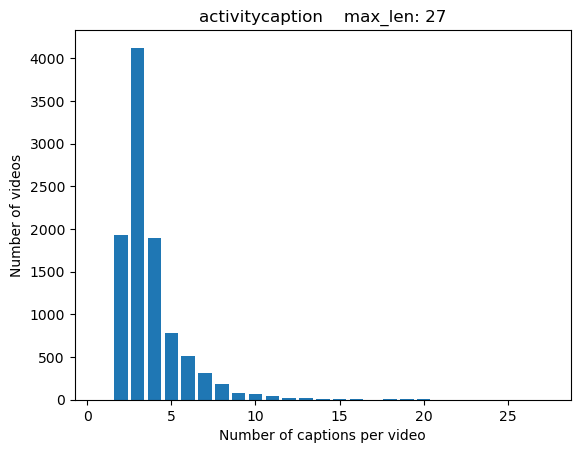

max_len:  10


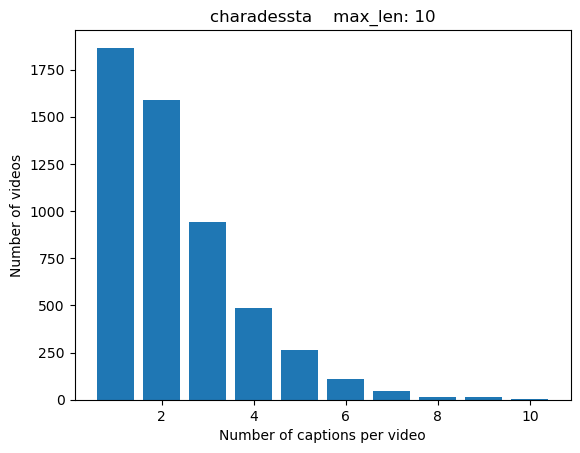

max_len:  2


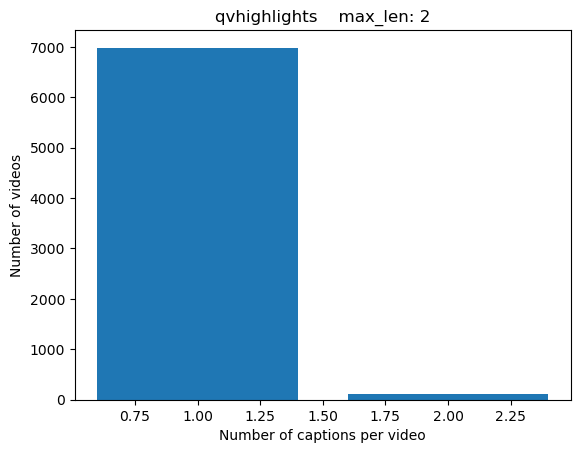

max_len:  211


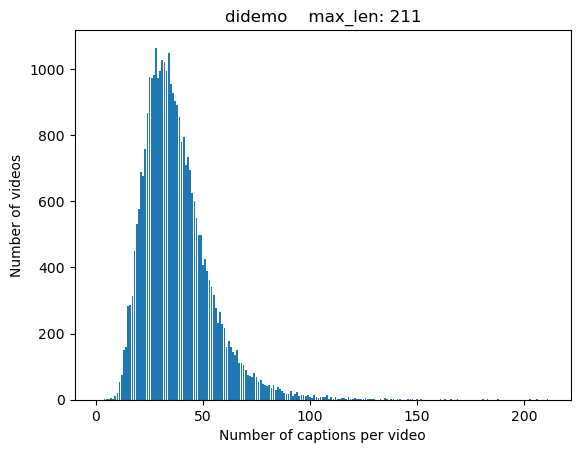

max_len:  376


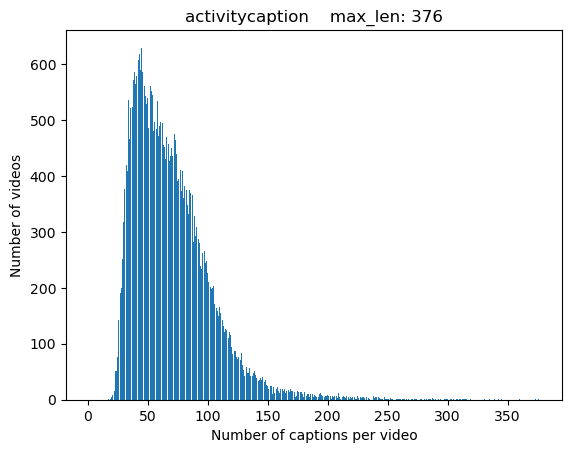

max_len:  69


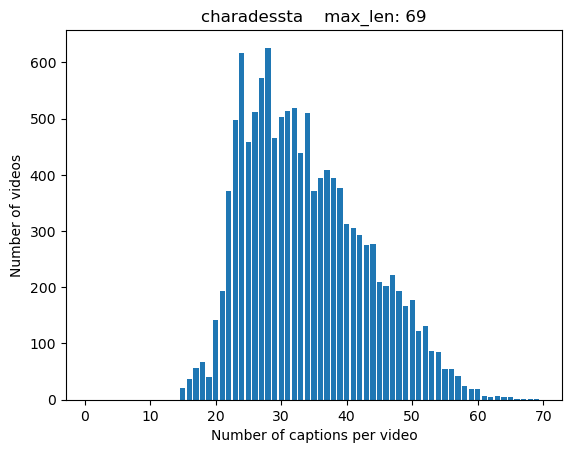

max_len:  203


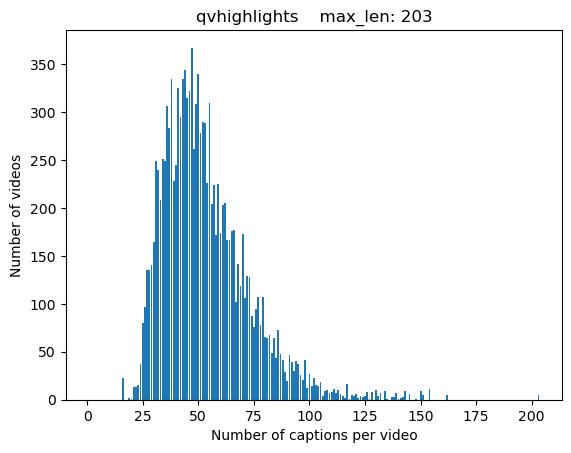

In [13]:
def draw_caption_num_per_video(data, name):
    max_len = 0
    for i in data:
        if len(i['captions']) > max_len:
            max_len = len(i['captions'])
            
    print("max_len: ", max_len)
    num_of_per_catogory = [i+1 for i in range(max_len)]   
    cnt_list = [0 for i in range(max_len)]
    for i in data:
        cnt_list[len(i['captions'])-1] += 1
        
    plt.bar(num_of_per_catogory, cnt_list)
    plt.xlabel('Number of captions per video')
    plt.ylabel('Number of videos')
    plt.title(name + f'    max_len: {max_len}')
    plt.show()
    
for i, dataset in enumerate(train_tree_list):
    draw_caption_num_per_video(dataset, dataset_name_list[i])
    
for i, dataset in enumerate(train_list):
    draw_caption_num_per_video(dataset, dataset_name_list[i])